CS5200 Spring 2024

Project 1 by Group 4 (Mengxian Cai, Siyi Ling, Yunxi Li, Zixiang Hu)  

Part 4. Python application


**1. Database setup and connection**

In [ ]:
import sqlite3
from sqlite3 import Error
import matplotlib.pyplot as plt
import numpy as np

# Function to create a connection to SQLite
def create_sqlite_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection successful")
    except Error as e:
        print(f"The error '{e}' occurred")
    return connection

# Create a connection to the provided database 'project1.db'
sqlite_connection = create_sqlite_connection('project1.db')

Connection successful


In [ ]:
# Function to execute an SQL statement in the connected database
def execute_sql(connection, statement):
    try:
        c = connection.cursor()
        c.execute(statement)
    except Error as e:
        print(f"The error '{e}' occurred")

# Function to execute an SQL statement in the connected database
# and store and return the result
def execute_sql_cursor(connection, query):
    c = connection.cursor()
    result = None
    try:
        c.execute(query)
        result = c.fetchall()
        return result
    except Error as e:
        print(f"The error '{e}' occurred")


**2. Task A**

Take an acceptance criteria from the user. Considering only papers that have at least two reviews, update the status of all papers to "accepted" if the average of their review scores is more than or equal to suh criteria, "rejected" if less than that. If the paper has less than two reviews its status should be marked as "undecided".

In [ ]:
# Function to take acceptance criteria score from the user
def take_acceptance_score_input():
  valid = False
  while not valid:
    acceptance_score = input('Please enter the acceptance score for paper reviews:\n')
    try:
      threshold = float(acceptance_score)
      if threshold < 0 or threshold > 5:
        print('Invalid score values. Scores must be between 0 and 5.')
      else:
        valid = True
        return acceptance_score
    except ValueError:
      print('Score must be a number.')

# Take the acceptance criteria score from the user in runtime
# Test with invalid score 6 first, then valid score 3.5
acceptance_threshold = take_acceptance_score_input()
print(f'You have set the acceptance criteria as {acceptance_threshold}.')

Please enter the acceptance score for paper reviews:
6
Invalid score values. Scores must be between 0 and 5.
Please enter the acceptance score for paper reviews:
3.5
You have set the acceptance criteria as 3.5.


In [ ]:
# Function to update the status of papers based on the acceptance criteria
# This function takes a string of acceptance_threshold as parameter
def update_papers_status(acceptance_threshold):
  update_papers_query = "\
  UPDATE Papers \
  SET status = \
    CASE \
      WHEN (SELECT count(average) FROM Author_Reviews_Paper a WHERE Papers.pid = paper_id) < 2 THEN 'undecided' \
      ELSE \
        CASE \
          WHEN (SELECT avg(average) FROM Author_Reviews_Paper a WHERE Papers.pid = paper_id) >= %s THEN 'accepted' \
          ELSE 'rejected' \
        END \
    END; \
  " % acceptance_threshold

  execute_sql(sqlite_connection, update_papers_query)

# Update the status of papers based on the acceptance criteria input from user
update_papers_status(acceptance_threshold)


**3. Task B**

Take a research area from the user. List the titles of accepted papers in that given research area in descending order of their average overall review scores.

In [ ]:
# Function to take research area input from the user
def take_research_area_input():
  valid = False
  while not valid:
    research_area = input('Please enter the research area of papers:\n')
    if research_area.isalpha():
        valid = True
        return research_area
    else:
      print('Please do not enter non-alphabetic text.')

# Take the research area from the user in runtime
# Available areas for test on project1.db include: 'potions', 'charms',
# 'transfiguration', 'astronomy','herbology','defence against dark arts'
# Test with 'potions'
research_area = take_research_area_input()
print(f'You have set the research area as {research_area}')

Please enter the research area of papers:
potions
You have set the research area as potions


In [ ]:
# Function to get all accepted papers from the given research area
# and rank them in descending order of their average overall review scores
# This function takes a string of research_area as parameter and returns the
# result of paper titles in a list
def get_accepted_papers_from_area(research_area):
  get_papers_query = " \
  SELECT p.title \
  FROM Papers p JOIN Paper_Research_Area pra ON p.pid = pra.paper_id \
  WHERE p.status = 'accepted' AND pra.area_name = '%s' \
  ORDER BY \
  (SELECT avg(average) FROM Author_Reviews_Paper arp WHERE arp.paper_id = p.pid) DESC; \
  " % research_area

  return execute_sql_cursor(sqlite_connection, get_papers_query)

# Retrieve all accepted papers based on the research area input from user
result_set = get_accepted_papers_from_area(research_area)
# Print out each paper for check
for paper in result_set:
  print(paper)

('Draught of Living Death: Countermeasures and Antidotes',)
('Amortentia Analysis: Unraveling the Complexities of the Love Potion',)


In [ ]:
# Test setting a different acceptance threshold: 2.5
another_threshold = take_acceptance_score_input()
print(f'You have set the acceptance criteria as {another_threshold}')

Please enter the acceptance score for paper reviews:
2.5
You have set the acceptance criteria as 2.5


In [ ]:
# Test update the paper status with new threshold and get accepted papers
# We can see one more paper is newly accepted
update_papers_status(another_threshold)
new_result_set = get_accepted_papers_from_area(research_area)
for paper in new_result_set:
  print(paper)

('Draught of Living Death: Countermeasures and Antidotes',)
('Amortentia Analysis: Unraveling the Complexities of the Love Potion',)
('The Efficacy of Polyjuice Potion in Mimicking Magical Abilities',)


In [ ]:
# Test another research_area: charms
another_area = take_research_area_input()
print(f'You have set the research are as {another_area}')

Please enter the research area of papers:
charms
You have set the research are as charms


In [ ]:
# Test get all accepted papers in charms area
charms_result_set = get_accepted_papers_from_area(another_area)
for paper in charms_result_set:
  print(paper)

('The Essence of Patronus Charm: Confronting Dementors with Light',)
('The Unseen Art: Invisibility Cloaks and their Magical Properties',)



**4. Task C**

For each research topic find the number of accepted, rejected and undecided papers, and present the result in some type of visualization.


In [ ]:
# Update paper status back with acceptance threshold of 3.5
update_papers_status(acceptance_threshold)

# Function to get number of accepted, rejected and undecided papers
# This function return a list of tuples where each tuple consists of area name,
# and the total count numbers of accepted/rejected/undecided papers
def get_papers_based_on_acceptance():
  get_papers_query = '''
    SELECT pra.area_name,
    count(CASE WHEN p.status = 'accepted' THEN 1 END) AS accepted_papers,
    count(CASE WHEN p.status = 'rejected' THEN 1 END) AS rejected_papers,
    count(CASE WHEN p.status = 'undecided' THEN 1 END) AS undecided_papers
    FROM Papers p JOIN Paper_Research_Area pra ON p.pid = pra.paper_id
    GROUP BY pra.area_name;
  '''
  return execute_sql_cursor(sqlite_connection, get_papers_query)

# Get the area name, counts of accepted/rejected/undecided papers
all_papers_set = get_papers_based_on_acceptance()
for line in all_papers_set:
  print(line)

('astronomy', 0, 0, 1)
('charms', 2, 0, 1)
('defence against dark arts', 2, 0, 0)
('herbology', 0, 1, 1)
('potions', 2, 1, 1)
('transfiguration', 0, 0, 1)


Make visualization using matplotlib.pyplot

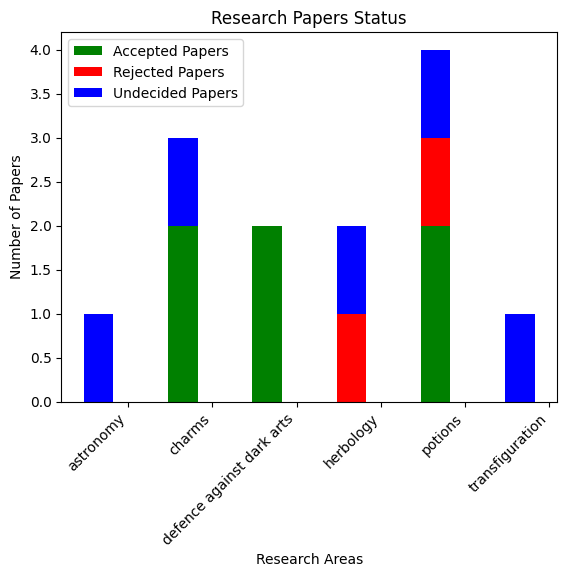

In [ ]:
# Extracting data for plotting
research_areas = [item[0] for item in all_papers_set]
accepted_papers = [item[1] for item in all_papers_set]
rejected_papers = [item[2] for item in all_papers_set]
undecided_papers = [item[3] for item in all_papers_set]

# Set the width of the bars
bar_width = 0.35

# Calculate the position of bars on X-axis
r1 = np.arange(len(research_areas))

# Plotting the stacked bars
plt.bar(r1, accepted_papers, width=bar_width, label='Accepted Papers', color='green')
plt.bar(r1, rejected_papers, width=bar_width, label='Rejected Papers', bottom=accepted_papers, color='red')
plt.bar(r1, undecided_papers, width=bar_width, label='Undecided Papers', bottom=[a + b for a, b in zip(accepted_papers, rejected_papers)], color='blue')

# Adding labels, title, legend
plt.xlabel('Research Areas')
plt.ylabel('Number of Papers')
plt.title('Research Papers Status')

plt.xticks([r + bar_width for r in range(len(research_areas))], research_areas, rotation=45, ha='right')
plt.legend()
plt.show()

**5. Task D**

Take a percentage threshold from the user. A review for a paper is inconsistent with respect to others if it has at least one average score different by more than such percentage (above or below) of the average of all average scores for that paper. For instance, given a particular paper and a percentage of 33%, if the average score for reviewer A is 4.5 and the average scores for both reviewers B and C is 3.0, then reviewer A's average score 4.5 would be inconsistent since it is 50% higher than the average of the average score of reviewers B and C. Considering that, list all reviewers responsible for inconsistent reviews.

In [ ]:
# Function to take percentage threshold from the user
def take_percentage_input():
  valid = False
  while not valid:
    percentage = input('Please enter the percentage threshold in the form of 0.XX:\n')
    try:
      threshold = float(percentage)
      if threshold < 0 or threshold > 1:
        print('Invalid threshold. Percentage must be between 0.00 and 1.00.')
      else:
        valid = True
        return percentage
    except ValueError:
      print('Percentage threshold must be a number.')

# Take the percentage threshold from the user in runtime
# Test with 33%, i.e., 0.33
percentage_threshold = take_percentage_input()
print(f'You have set the percentage threshold as {percentage_threshold}')

Please enter the percentage threshold in the form of 0.XX:
0.33
You have set the percentage threshold as 0.33


In [ ]:
# Function to get inconsistent reviewers
# This function takes a string of percentage_threshold as parameter and returns
# the reviewers represented by their unique identifier i.e., email in a list
def get_inconsistent_reviewers(percentage_threshold):
  get_inconsistent_reviewers_query = " \
  SELECT DISTINCT a1.reviewer_email \
  FROM Author_Reviews_Paper a1 \
  JOIN ( \
    SELECT paper_id, avg(average) AS overall_avg \
    FROM Author_Reviews_Paper \
    GROUP BY paper_id \
  ) AS a2 ON a1.paper_id = a2.paper_id \
  WHERE abs(a1.average - a2.overall_avg) > %s * a2.overall_avg; \
  " % percentage_threshold

  return execute_sql_cursor(sqlite_connection, get_inconsistent_reviewers_query)

# Get inconsistent reviwers based on the percentage input from user
inconsistent_reviewers = get_inconsistent_reviewers(percentage_threshold)
for reviewer in inconsistent_reviewers:
  print(reviewer)

('m.mcgonagall@hogwarts.uk',)
('s.snape@hogwarts.uk',)


**6. Close the database connection**


In [ ]:
sqlite_connection.close()